In [148]:
include("settings.jl")
move_to_datadir(supervisor, "mfld_top");

import GeneralAttractors: by_column
import IterTools: product as itprod


## Run simulations

In [157]:
network = "sphere"

x, y, z = if network == "line"
    -6:.05:6, nothing, nothing
elseif network == "ring"
    0:.01:2π, nothing, nothing
elseif network == "plane"
    -10:.5:10, -10:.5:10, nothing
elseif network == "cylinder"
    0:.1:2π, -5:.1:5, nothing
elseif network == "torus"
    0:.1:2π, 0:.1:2π, nothing
elseif network == "mobius"
    -2:.1:2, 0:.1:2π, nothing
elseif network == "sphere"
    -1:.15:1, -1:.15:1, -1:.15:1
else
    error()
end

pts = []
if !isnothing(z)
    for _x in x, _y in y, _z in z
        push!(pts, [_x, _y, _z])
    end
elseif !isnothing(y)
    for _x in x, _y in y
            push!(pts, [_x, _y])
    end
else
    pts = [[_x] for _x in x]
end
println("Running $(length(pts)) simulations")
if length(pts) > 800
    @warn "Too many points! " length(pts)
end


if network == "sphere"
    #normalize points
    pts = map(p -> p ./ norm(p), pts) |> collect
end
length(pts)

Running 2744 simulations


┌ Warning: Too many points! 
│   length(pts) = 2744
└ @ Main /Users/federicoclaudi/Documents/Github/GeneralAttractorsTheory/paper/f3_F_tuning_cures.ipynb:35


2744

In [158]:
# run
can = make_single_can(network)
states, points = [], []
for (i, pt) in enumerate(pts)
    h, x = simulate_constant_traj_random_init(can, 25, dt, 15, τ, b₀; x₀=pt, )
    push!(states, h.S[:, 1, end])
    push!(points, x[end, :])
end

# stack
S = hcat(states...)
X = hcat(points...);


## Tuning curve on activity in state space

In [167]:
params = AnalysisParameters(
    max_nPC = 100,  
    pca_pratio = 0.9999999999999999999999999999999999,     
    n_isomap_dimensions = 3,
    isomap_k = 8,
    isomap_downsample = 8,
)


pca, S_pca = pca_dimensionality_reduction(S, params)
iso, S_iso = isomap_dimensionality_reduction(S_pca, params)
nothing

┌ Info: PCA dimensionality reduction
│   size(S) = (2304, 2744)
│   params.max_nPC = 100
│   params.pca_pratio = 1.0
│   nPC = 100
└ @ GeneralAttractors.Analysis.ManifoldAnalysis /Users/federicoclaudi/Documents/Github/GeneralAttractorsTheory/src/analysis/topology.jl:97
┌ Info: pca fitting completed 100 PCs
│   size(S_pca_space) = (100, 2744)
└ @ GeneralAttractors.Analysis.ManifoldAnalysis /Users/federicoclaudi/Documents/Github/GeneralAttractorsTheory/src/analysis/topology.jl:100


┌ Info: Performing ISOMAP
│   size(X) = (100, 2744)
│   params.n_isomap_dimensions = 3
│   params.isomap_downsample = 8
│   params.isomap_k = 8
└ @ GeneralAttractors.Analysis.ManifoldAnalysis /Users/federicoclaudi/Documents/Github/GeneralAttractorsTheory/src/analysis/topology.jl:124
┌ Info: isomap fitting completed
│   size(M) = (3, 2744)
└ @ GeneralAttractors.Analysis.ManifoldAnalysis /Users/federicoclaudi/Documents/Github/GeneralAttractorsTheory/src/analysis/topology.jl:132


In [191]:
idx, camera, ms = if network == "line"
    200, (20, 40), 4
elseif network == "ring"
    200, (20, 40), 4
elseif network == "plane"
    1800, (20, 80), 4
elseif network == "cylinder"
    1400, (20, 80), 4

elseif network == "torus"
    570, (70, 40), 4.5
elseif network == "mobius"
    500, (190, 30), 4
elseif network == "sphere"
    1600, (20, 40), 7
else
    error()
end



(1600, (20, 40), 7)

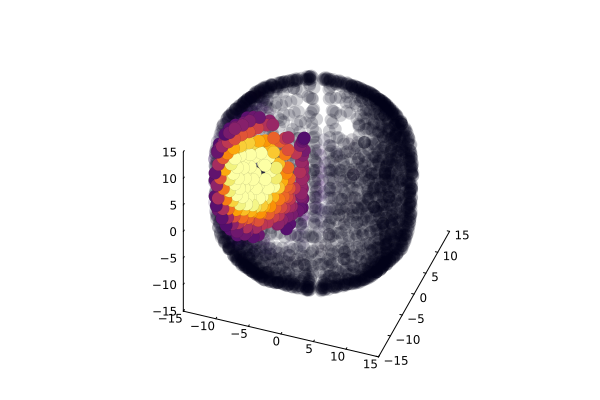

In [192]:
active = S[idx, :] .> 0.1
inactive  = S[idx, :] .< 0.1

if network ∉ ("line", "ring")
    plt = scatter(eachrow(S_iso[:, inactive])..., marker_z=S[idx, inactive], 
        msa=0, msw=0, 
        ms=ms, 
        clim=(-.02, .5), alpha=.18,
        legend=false, grid=false, 
        # xticks=[], yticks=[], zticks=[],
        camera=camera,
        xlim=[-15, 15],
        ylim=[-15, 15],
        zlim=[-15, 15]
    )
    scatter!(eachrow(S_iso[:, active])..., marker_z=S[idx, active], 
        msa=.2, msw=0, ms=ms, clim=(-.02, .5), 

    )
else
    plt = scatter(
        S_iso[1, :],
        S_iso[2, :],
        S[idx, :],
        marker_z=S[idx, :],
        xlim=[-20, 20],
        ylim=[-20, 20],
        clim=(-.02, .5), alpha=1,
        legend=false, grid=false, 
    )
end

save_plot(supervisor, plt, "f3_N_tuning_cuvres_$(network)")
plt

## Activity on M

In [174]:
function mapping_tours(x, y)
    x = x ./ 2π .* 20 .- 10
    y = y ./ 2π .* 20 .- 10
    return x, y
end
mapping_tours(x) = mapping_tours(x...)
Base.identity(x, y) = x, y

nothing

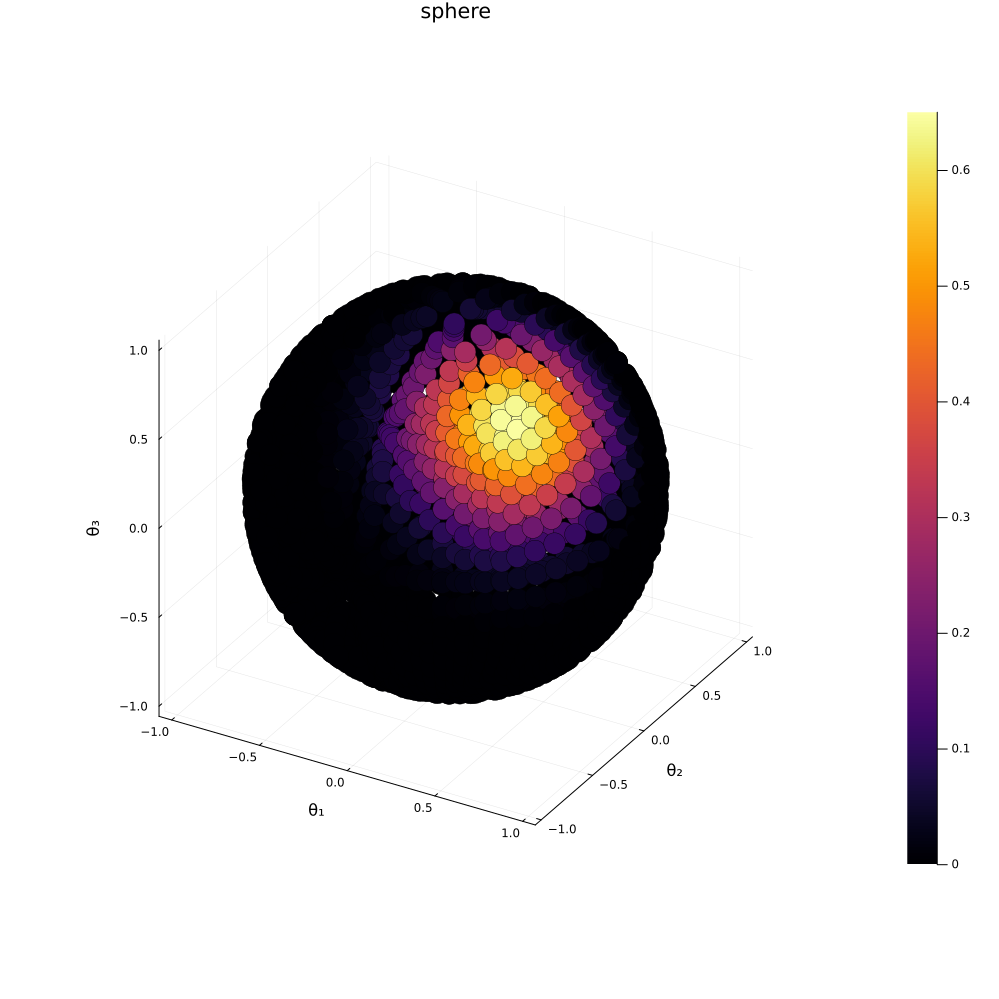

In [190]:
φ = if network == "torus"
        mapping_tours
else
        identity
end


# M = by_column(φ, hcat(pts...))
M = hcat(pts...)

if network ∉ ("line", "ring")
        plt = plot(size=(1000, 1000))
        scatter!(
                eachrow(M)...,
                marker_z = S[idx, :],
                aspect_ratio=:equal,
                xlabel="θ₁", ylabel="θ₂", zlabel="θ₃",
                label=nothing, msa=.2, msw=.2, ms=12,
                title = network
        )
else
        plt = scatter(
                M[1, :],
                S[idx, :],
                marker_z = S[idx, :],
                xlabel="θ₁", ylabel="θ₂", zlabel="θ₃",
                label=nothing, msa=.2, msw=.2, ms=4,
                title = network,
                grid=false,
                ylim=[0,1.4]

        )
end
save_plot(supervisor, plt, "f3_M_tuning_cuvres_$(network)")
plt